### Packages

In [1]:
from typing import Any, List, Optional, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import xgboost
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    precision_score,
    recall_score,
    average_precision_score
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import warnings
warnings.filterwarnings("ignore")

### Data

In [2]:
df = pd.read_csv("../data/dataset.csv", sep=";")
df.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  float64
 2   account_amount_added_12_24m          99976 non-null  int64  
 3   account_days_in_dc_12_24m            88140 non-null  float64
 4   account_days_in_rem_12_24m           88140 non-null  float64
 5   account_days_in_term_12_24m          88140 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  40661 non-null  float64
 7   account_status                       45603 non-null  float64
 8   account_worst_status_0_3m            45603 non-null  float64
 9   account_worst_status_12_24m          33215 non-null  float64
 10  account_worst_status_3_6m            42274 non-null  float64
 11  account_worst_status_6_12m  

### Identifying Variables and Targets

- Unique identifier: `uuid`
- Target: `default`
- Potential Features: all other columns.

In [4]:
target = "default"
unique_id = "uuid"

Since there are some missing entries for the target variable, we need to drop these entries from the dataset.

In [5]:
df = df.dropna(subset=[target])
df.shape

(89976, 43)

### EDA

+ Gathering features according to their intrinsic type

In [6]:
all_fields = list(filter(lambda x: x not in [target, unique_id], df.columns))

cat_features = list(filter(lambda x: "status" in x, all_fields))
bool_features = ["has_paid"]
string_features = list(filter(lambda x: df[x].dtype.name == "object", all_fields))
numeric_features = list(
    set(all_fields) -
    set(cat_features) - 
    set(bool_features) - 
    set(string_features)
)

feature_groups = {
    "category": cat_features,
    "bool": bool_features,
    "str": string_features,
    "float64": numeric_features,
}

+ Converting them to their final type

In [7]:
def convert_type(df: pd.DataFrame, cols: List[str], target_type: Any) -> pd.DataFrame:
    return df[cols].astype(target_type)

for feat_type, feat_group in feature_groups.items():
    df[feat_group] = convert_type(df, feat_group, feat_type)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89976 entries, 0 to 89975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   uuid                                 89976 non-null  object  
 1   default                              89976 non-null  float64 
 2   account_amount_added_12_24m          89976 non-null  float64 
 3   account_days_in_dc_12_24m            79293 non-null  float64 
 4   account_days_in_rem_12_24m           79293 non-null  float64 
 5   account_days_in_term_12_24m          79293 non-null  float64 
 6   account_incoming_debt_vs_paid_0_24m  36619 non-null  float64 
 7   account_status                       41042 non-null  category
 8   account_worst_status_0_3m            41042 non-null  category
 9   account_worst_status_12_24m          29921 non-null  category
 10  account_worst_status_3_6m            38038 non-null  category
 11  account_worst_s

##### Target

This is a highly imbalanced classification problem - as we would expect from a default prediction.

In [9]:
df[target].value_counts()

0.0    88688
1.0     1288
Name: default, dtype: int64

In [10]:
df[target].value_counts() / len(df)

0.0    0.985685
1.0    0.014315
Name: default, dtype: float64

*Some useful functions for the downstream analysis*

In [11]:
def display_summary_statistics(
    df: pd.DataFrame,
    cols: List[str],
    target: str,
    categorical: bool = True
) -> None:
    print("#"*10 + "STATISTICS" + "#"*10)
    display(df[cols].describe())
    print("#"*10 + "TARGET STATS" + "#"*10)
    if categorical:
        for col in cols:
            df_count = pd.pivot_table(
                data=df, index=col, values=unique_id, columns=target, aggfunc="count"
            )
            display((df_count.T / df_count.T.sum()).T)
    else:
        display(df.groupby(target)[cols].describe())
    print("\n" + "#"*10 + "MISSING RATE" + "#"*10, end="\n\n")
    print(df[cols].isnull().mean() * 100)

In [12]:
def plot_count(df: pd.DataFrame, cols: List[str], hue: Optional[str] = None) -> None:
    ncols = 2
    nrows = len(cols) // ncols + len(cols) % ncols
    fig = plt.figure(figsize=(16, len(cols) * 3))
    for i, col in enumerate(cols):
        ax = plt.subplot(nrows, ncols, i+1)
        sns.countplot(data=df, y=col, hue=hue, ax=ax)
        ax.set_title(col)
    
    plt.tight_layout()
    plt.show()

In [13]:
def plot_numeric(df: pd.DataFrame, cols: List[str], hue: Optional[str] = None) -> None:
    ncols = 2
    nrows = len(cols)
    fig = plt.figure(figsize=(16, len(cols) * 3))
    for i, col in tqdm(enumerate(cols)):
        ax = plt.subplot(nrows, ncols, ncols*i+1)
        sns.boxplot(data=df, y=col, x=hue, ax=ax)
        ax.set_title(col)
        ax = plt.subplot(nrows, ncols, ncols*(i+1))
        if hue:
            for cat in df[hue].unique():
                sns.distplot(df.loc[df[hue] == cat, col], bins=30, ax=ax, label=f"Category {cat}")
                ax.legend()
        else:
            sns.distplot(df[col], bins=30, ax=ax)
        ax.set_title(col)
    
    plt.tight_layout()
    plt.show()

In [14]:
def plot_correlation_heatmap(df: pd.DataFrame, cols: List[str]) -> None:
    df_corr = df[cols].corr()
    base = np.zeros_like(df_corr)
    base[np.triu_indices_from(df_corr)] = 1
    _, ax = plt.subplots(1, 1, figsize=(10, 8))
    sns.heatmap(
        df_corr, mask=base, vmin=-1, vmax=1, annot=True, fmt=".1f", ax=ax
    )
    plt.show()

##### Category Features

Since each feature has at most 5 different categories, we won't suffer from dimensionality curse in this context.

In [15]:
display_summary_statistics(df, cat_features, target)

##########STATISTICS##########


,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,worst_status_active_inv
count,41042.0,41042.0,29921.0,38038.0,35663.0,89976,89976,89976,89976,89976,89976,27436.0
unique,4.0,4.0,4.0,4.0,4.0,5,5,5,4,5,5,3.0
top,1.0,1.0,1.0,1.0,1.0,1,1,1,1,1,1,1.0
freq,39345.0,34524.0,21142.0,31708.0,27610.0,64594,56470,51381,44513,45874,42350,24230.0


##########TARGET STATS##########


default,0.0,1.0
account_status,,
1.0,0.983022,0.016978
2.0,0.903379,0.096621
3.0,0.714286,0.285714
4.0,0.000000,1.000000


default,0.0,1.0
account_worst_status_0_3m,,
1.0,0.988240,0.011760
2.0,0.941880,0.058120
3.0,0.856784,0.143216
4.0,0.765306,0.234694


default,0.0,1.0
account_worst_status_12_24m,,
1.0,0.992243,0.007757
2.0,0.967151,0.032849
3.0,0.911602,0.088398
4.0,0.806867,0.193133


default,0.0,1.0
account_worst_status_3_6m,,
1.0,0.988804,0.011196
2.0,0.951908,0.048092
3.0,0.901747,0.098253
4.0,0.684211,0.315789


default,0.0,1.0
account_worst_status_6_12m,,
1.0,0.990402,0.009598
2.0,0.964222,0.035778
3.0,0.874396,0.125604
4.0,0.720207,0.279793


default,0.0,1.0
status_last_archived_0_24m,,
0,0.970806,0.029194
1,0.994148,0.005852
2,0.971506,0.028494
3,0.850591,0.149409
5,0.500000,0.500000


default,0.0,1.0
status_2nd_last_archived_0_24m,,
0,0.972660,0.027340
1,0.994847,0.005153
2,0.979851,0.020149
3,0.874720,0.125280
5,1.000000,0.000000


default,0.0,1.0
status_3rd_last_archived_0_24m,,
0,0.974017,0.025983
1,0.995738,0.004262
2,0.977153,0.022847
3,0.900088,0.099912
5,0.666667,0.333333


default,0.0,1.0
status_max_archived_0_6_months,,
0,0.973695,0.026305
1,0.995664,0.004336
2,0.988059,0.011941
3,0.933800,0.066200


default,0.0,1.0
status_max_archived_0_12_months,,
0,0.971255,0.028745
1,0.994921,0.005079
2,0.991435,0.008565
3,0.929756,0.070244
5,0.750000,0.250000


default,0.0,1.0
status_max_archived_0_24_months,,
0,0.970806,0.029194
1,0.994900,0.005100
2,0.992678,0.007322
3,0.937773,0.062227
5,0.882353,0.117647


default,0.0,1.0
worst_status_active_inv,,
1.0,0.984441,0.015559
2.0,0.959358,0.040642
3.0,0.896774,0.103226



##########MISSING RATE##########

account_status                     54.385614
account_worst_status_0_3m          54.385614
account_worst_status_12_24m        66.745577
account_worst_status_3_6m          57.724282
account_worst_status_6_12m         60.363875
status_last_archived_0_24m          0.000000
status_2nd_last_archived_0_24m      0.000000
status_3rd_last_archived_0_24m      0.000000
status_max_archived_0_6_months      0.000000
status_max_archived_0_12_months     0.000000
status_max_archived_0_24_months     0.000000
worst_status_active_inv            69.507424
dtype: float64


In [16]:
df[cat_features].describe()

,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,worst_status_active_inv
count,41042.0,41042.0,29921.0,38038.0,35663.0,89976,89976,89976,89976,89976,89976,27436.0
unique,4.0,4.0,4.0,4.0,4.0,5,5,5,4,5,5,3.0
top,1.0,1.0,1.0,1.0,1.0,1,1,1,1,1,1,1.0
freq,39345.0,34524.0,21142.0,31708.0,27610.0,64594,56470,51381,44513,45874,42350,24230.0


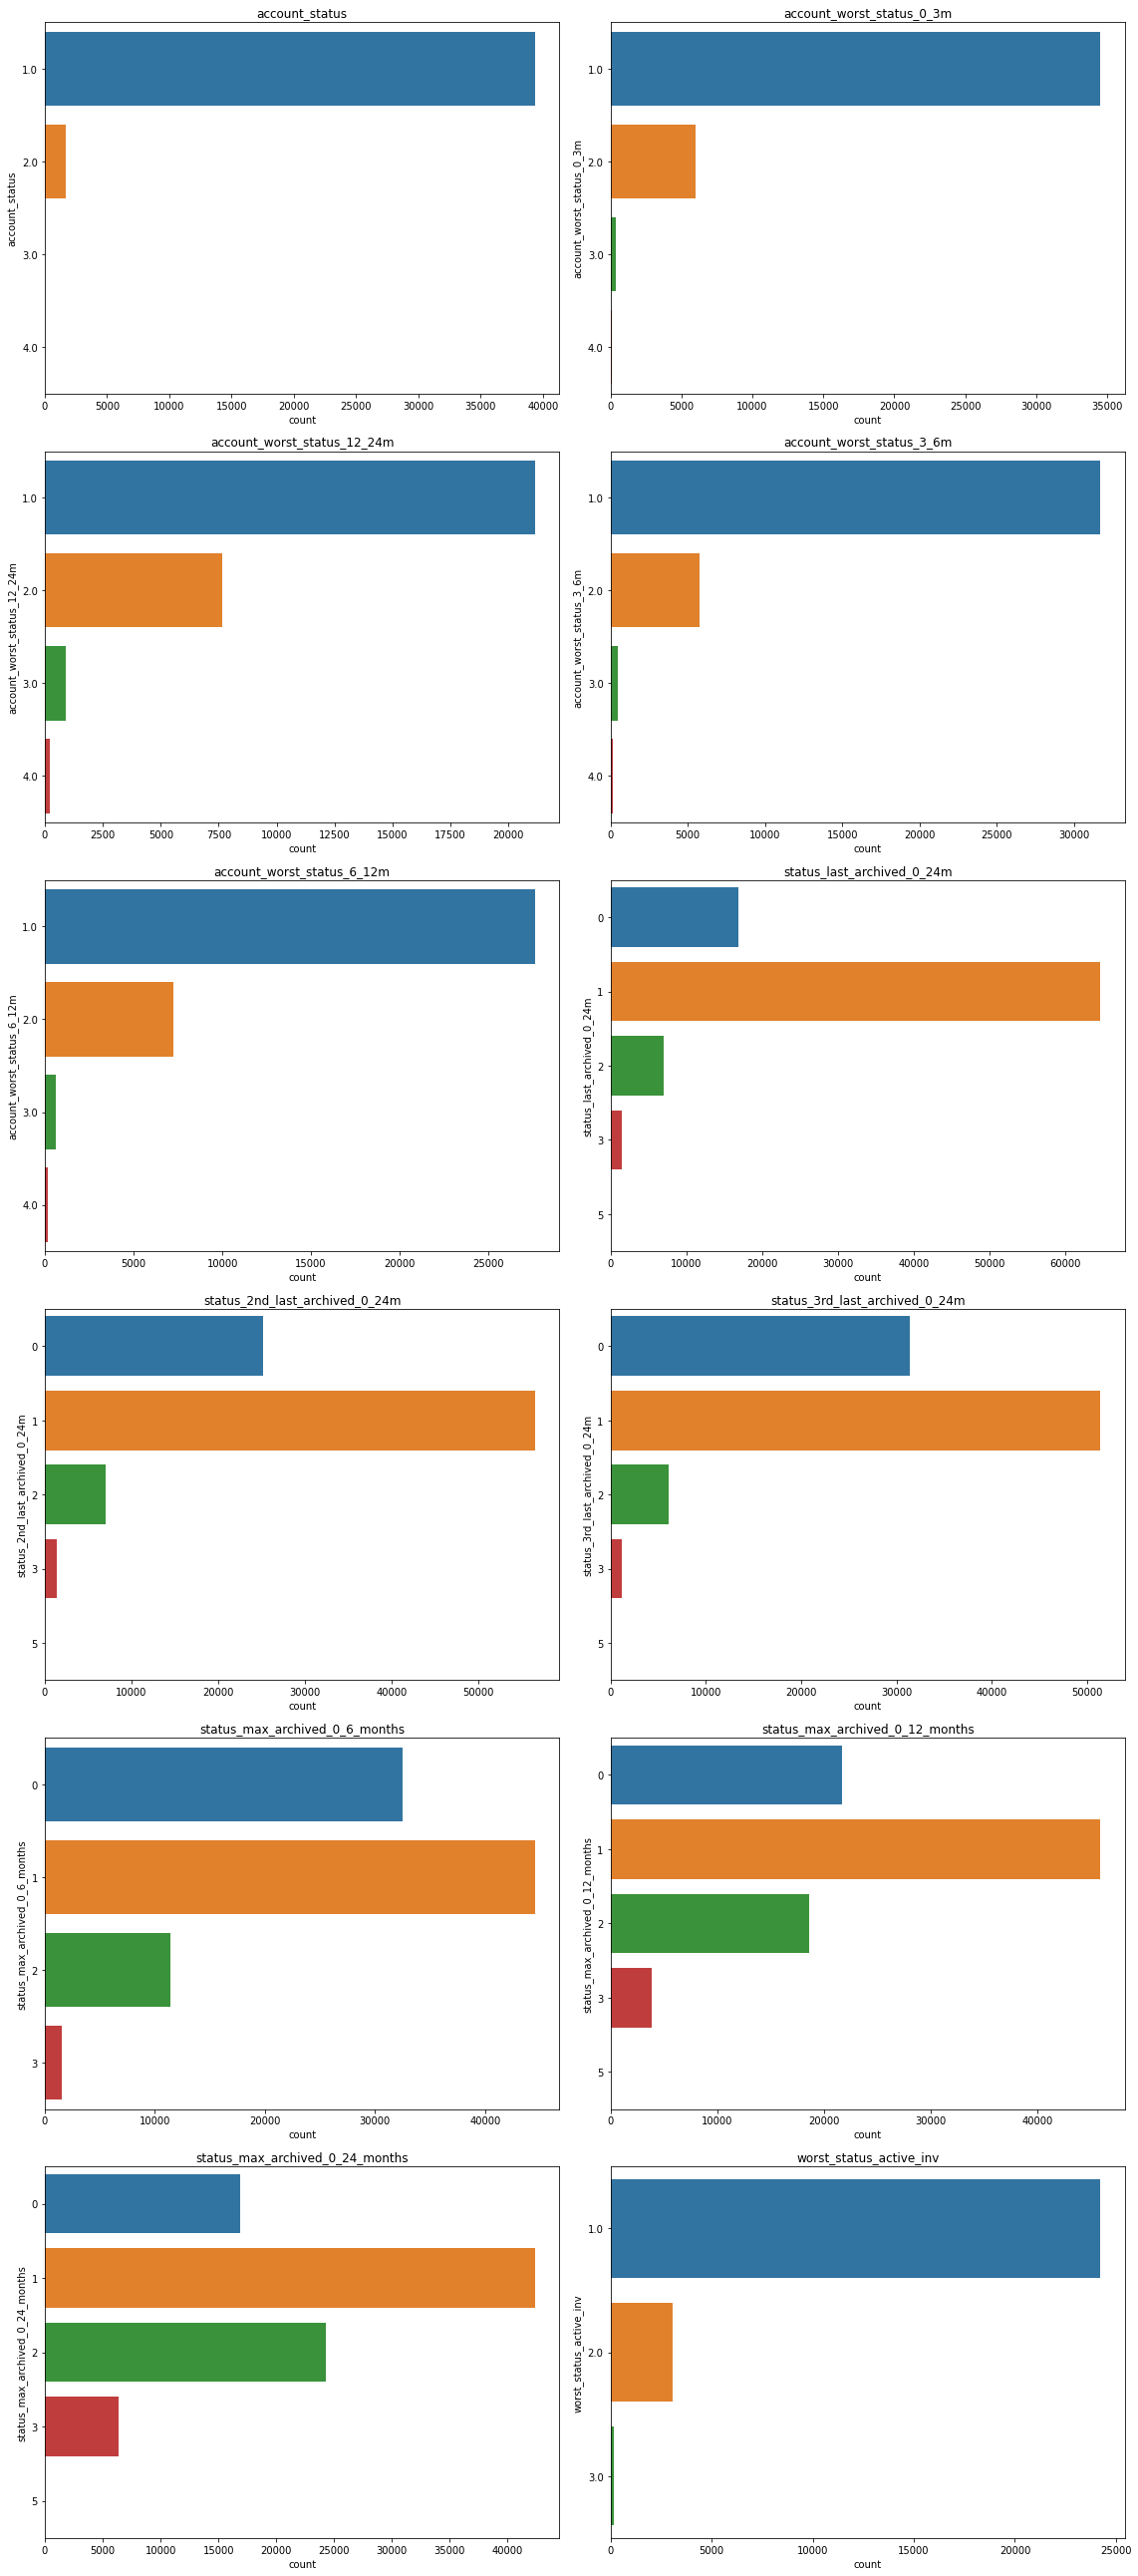

In [17]:
plot_count(df, cat_features)

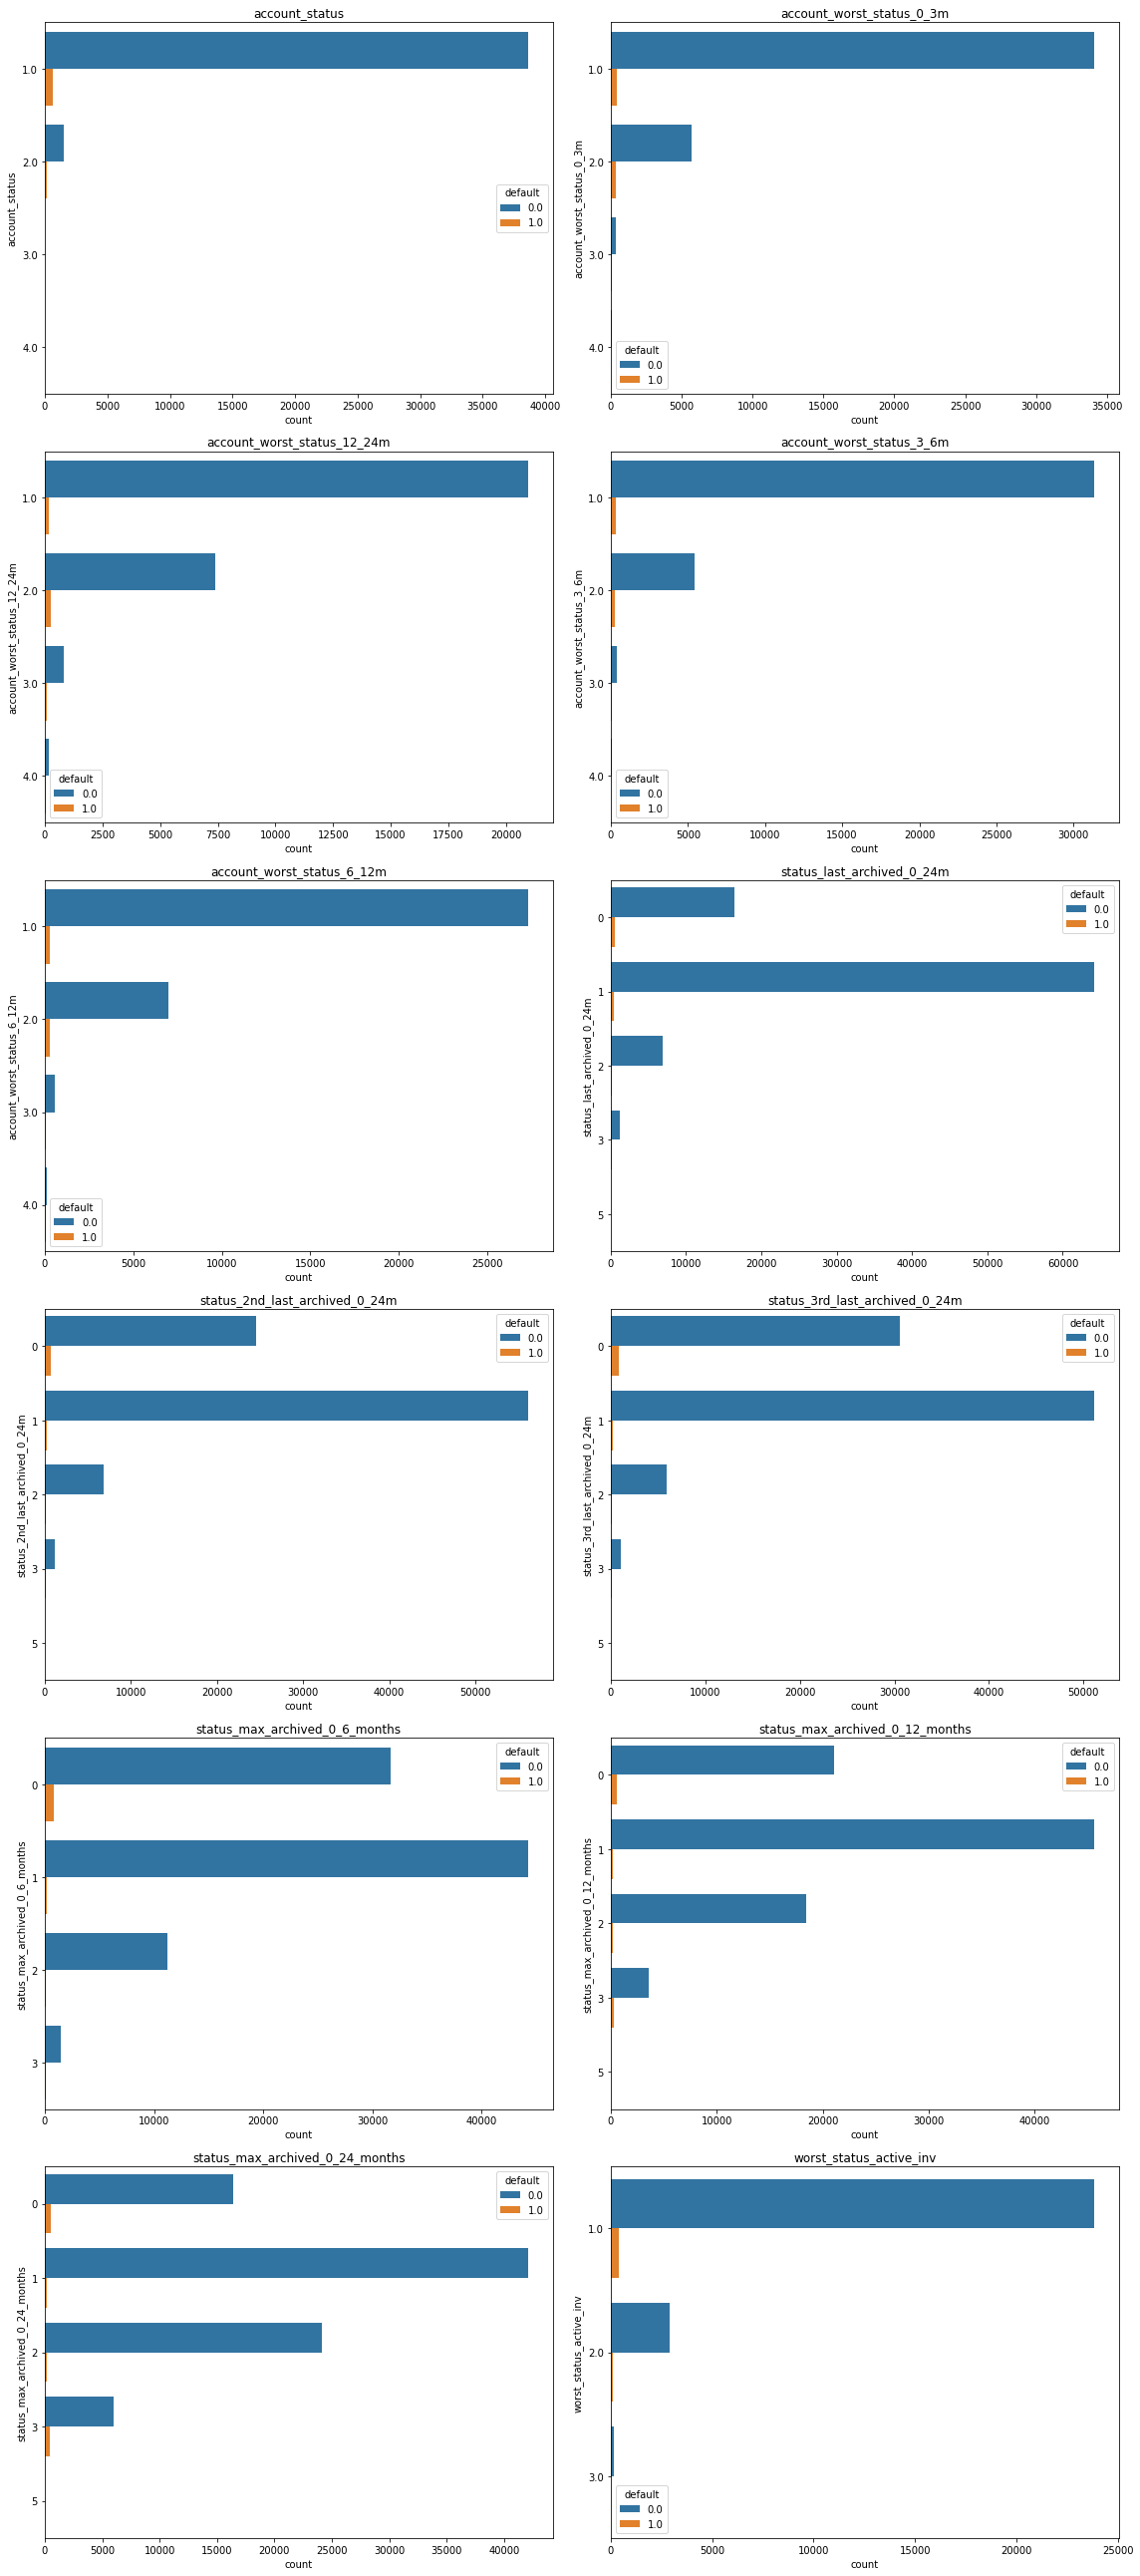

In [18]:
plot_count(df, cat_features, hue=target)

For the features regarding `worst_status`, we can clearly see that the higher the value, the hogher the lift for targeted individuals (default = 1.0). Since they all have a high missing rate, a reasonable approach is to have the maximum value over all entries - hence, we would have something similar to `account_worst_status_0_24m` and this feature would potentially replace all others with a lower missing rate.

In [19]:
df["account_worst_status_0_24m"] = np.max(
    df.loc[:, filter(lambda x: x.startswith("account_worst_status"), df.columns)],
    axis=1
)

In [20]:
display_summary_statistics(df, ["account_worst_status_0_24m"], target)

##########STATISTICS##########


,account_worst_status_0_24m
count,41042.000000
mean,1.440013
std,0.635231
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


##########TARGET STATS##########


default,0.0,1.0
account_worst_status_0_24m,,
1.0,0.991103,0.008897
2.0,0.974036,0.025964
3.0,0.908641,0.091359
4.0,0.780384,0.219616



##########MISSING RATE##########

account_worst_status_0_24m    54.385614
dtype: float64


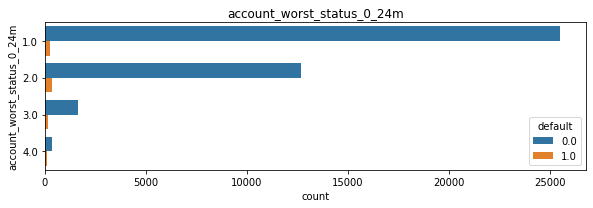

In [21]:
plot_count(df, ["account_worst_status_0_24m"], hue=target)

From the analysis above, we can select following features for further development:

- `account_status`: Even though the missing rate is quite high (54%), we can see a clear pattern of discrimiation for higher values;

- `account_worst_status_0_24m`: Since we reduce dimensionality with a more representative feature;

- `status_last_archived_0_24m`: Low missing rate and fair discrimination between classes;

- `status_2nd_last_archived_0_24m`: Low missing rate and fair discrimination between classes;

- `status_3rd_last_archived_0_24m`: Low missing rate and fair discrimination between classes;

- `status_max_archived_0_6_months`: Low missing rate and fair discrimination between classes;

- `status_max_archived_0_12_months`: Low missing rate and fair discrimination between classes;

- `status_max_archived_0_24_months`: Low missing rate and fair discrimination between classes.


Regarding preprocessing, all these features already have an encoding that represents the risk associated to the account. So we don't need to preprocess them.

##### Boolean Features

In [22]:
display_summary_statistics(df, bool_features, target=target)

##########STATISTICS##########


,has_paid
count,89976
unique,2
top,True
freq,76570


##########TARGET STATS##########


default,0.0,1.0
has_paid,,
False,0.976578,0.023422
True,0.987280,0.012720



##########MISSING RATE##########

has_paid    0.0
dtype: float64


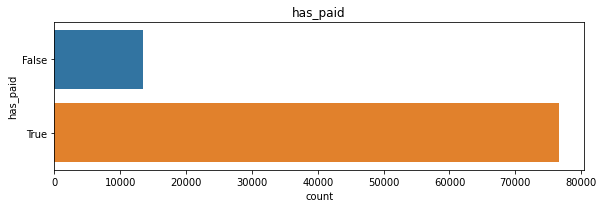

In [23]:
plot_count(df, bool_features)

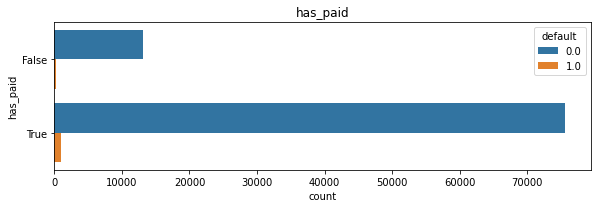

In [24]:
plot_count(df, bool_features, hue=target)

From the analysis above, we can use `has_paid` for further model training, since no entries are missing and when it is set to `False` we can observe twice as many individuals that default.

Regarding preprocessing, we need to convert it into a numeric format.

- `False` = 0
- `True` = 1

In [25]:
df["has_paid"] = df["has_paid"].astype(int)

##### String Features

`merchant_category` is a much more granular view of `merchant_group`, since let's consider only `merchant_group` for now

In [26]:
df[string_features].describe()

,merchant_category,merchant_group,name_in_email
count,89976,89976,89976
unique,57,12,8
top,Diversified entertainment,Entertainment,F+L
freq,34781,43940,36358


In [27]:
string_features.remove("merchant_category")

In [28]:
display_summary_statistics(df, string_features, target)

##########STATISTICS##########


,merchant_group,name_in_email
count,89976,89976
unique,12,8
top,Entertainment,F+L
freq,43940,36358


##########TARGET STATS##########


default,0.0,1.0
merchant_group,,
Automotive Products,0.979953,0.020047
Children Products,0.987430,0.012570
Clothing & Shoes,0.977317,0.022683
Electronics,0.976701,0.023299
Entertainment,0.992581,0.007419
Erotic Materials,0.961194,0.038806
Food & Beverage,0.909091,0.090909
Health & Beauty,0.984216,0.015784
Home & Garden,0.981493,0.018507


default,0.0,1.0
name_in_email,,
F,0.987664,0.012336
F+L,0.987513,0.012487
F1+L,0.986293,0.013707
Initials,0.958333,0.041667
L,0.976431,0.023569
L1+F,0.987858,0.012142
Nick,0.980656,0.019344
no_match,0.981052,0.018948



##########MISSING RATE##########

merchant_group    0.0
name_in_email     0.0
dtype: float64


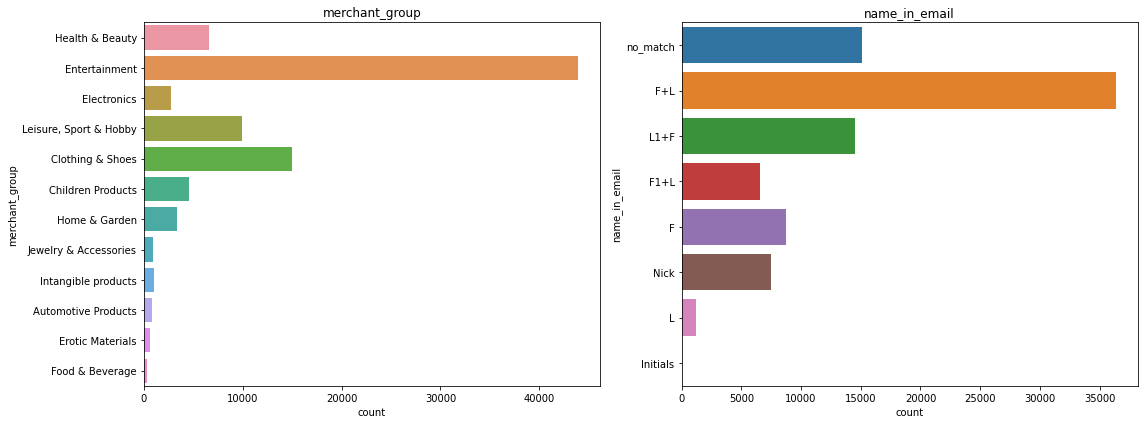

In [29]:
plot_count(df, string_features)

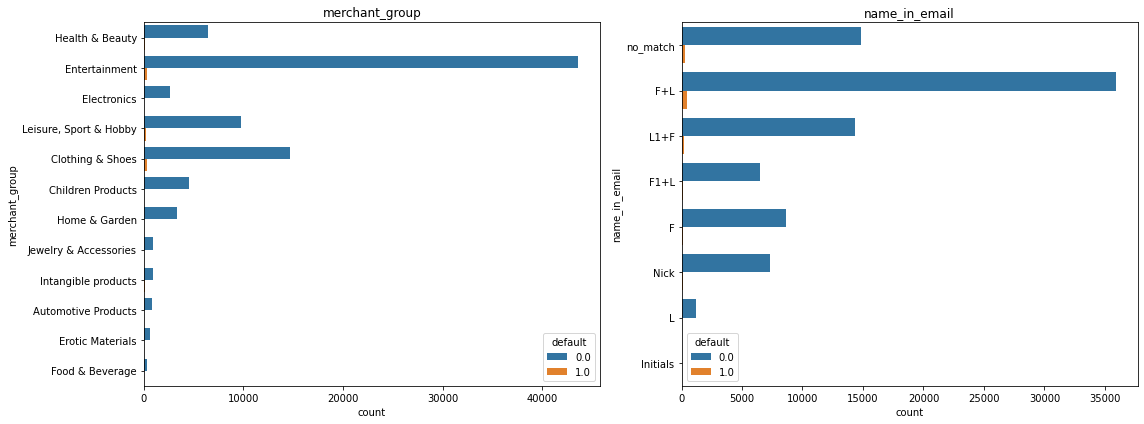

In [30]:
plot_count(df, string_features, target)

From the analysis above, we can use both featurs - `merchant_group` and `name_in_email` - for further model training, since no entries are missing and they potentially contribute to identifying individuals who default.

Regarding preprocessing:

- `merchant_group`: It will be useful to account for all groups, since they show different default rates. "Erotic Materials" and "Food & Beverage" show way higher default rates, whereas other groups are way less risky, such as "Entertainment".

- `name_in_email`: Here some categories are irrelevant, so it should be more useful to consider only the relevant ones - i.e., "L" and "Initials", provided that all the others have similar rates.

Regargind preprocessing, both of them will require numeric encoding, so that the algorithm can use them accordingly. Since there is no logical ordering, we will use **One Hot Encoding**.

In [31]:
df["name_in_email"] = np.where(
    ~df["name_in_email"].isin(["Initials", "L"]),
    "Others",
    df["name_in_email"]
)

In [32]:
df["name_in_email"].value_counts()

Others      88764
L            1188
Initials       24
Name: name_in_email, dtype: int64

##### Numeric Features

In [33]:
display_summary_statistics(df, numeric_features, target=target, categorical=False)

##########STATISTICS##########


,account_incoming_debt_vs_paid_0_24m,avg_payment_span_0_12m,avg_payment_span_0_3m,num_arch_rem_0_12m,max_paid_inv_0_24m,sum_capital_paid_account_12_24m,num_active_inv,num_arch_dc_12_24m,max_paid_inv_0_12m,num_arch_dc_0_12m,...,time_hours,account_days_in_rem_12_24m,sum_capital_paid_account_0_12m,account_amount_added_12_24m,num_arch_ok_0_12m,num_active_div_by_paid_inv_0_12m,age,account_days_in_dc_12_24m,num_arch_written_off_0_12m,num_unpaid_bills
count,36619.000000,68508.000000,45594.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,...,89976.000000,79293.000000,89976.000000,8.997600e+04,89976.000000,69318.000000,89976.000000,79293.000000,73671.000000,89976.000000
mean,1.330536,17.977933,14.960416,0.467258,11244.316873,6579.854317,0.598704,0.059749,9224.090658,0.061761,...,15.336351,5.073840,10833.659832,1.227615e+04,7.289777,0.114667,36.019050,0.217333,0.000109,2.142249
std,26.924730,12.804216,10.259607,1.351350,15257.546930,19192.785345,1.544341,0.368212,13576.947551,0.373620,...,5.030674,22.957817,26494.078628,3.546356e+04,16.074663,0.293679,12.999713,5.629972,0.010420,6.296635
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000278,0.000000,0.000000,0.000000e+00,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000
25%,0.000000,10.800000,8.400000,0.000000,3340.000000,0.000000,0.000000,0.000000,2000.000000,0.000000,...,11.629167,0.000000,0.000000,0.000000e+00,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000
50%,0.153818,14.904762,13.000000,0.000000,7585.000000,0.000000,0.000000,0.000000,6055.000000,0.000000,...,15.800833,0.000000,0.000000,0.000000e+00,2.000000,0.000000,34.000000,0.000000,0.000000,0.000000
75%,0.664694,21.040124,18.222222,0.000000,13810.000000,100.000000,1.000000,0.000000,11380.000000,0.000000,...,19.548056,0.000000,9098.250000,4.984250e+03,7.000000,0.100000,45.000000,0.000000,0.000000,2.000000
max,3914.000000,260.000000,86.000000,42.000000,279000.000000,341859.000000,47.000000,13.000000,279000.000000,16.000000,...,23.999722,365.000000,571475.000000,1.128775e+06,261.000000,9.000000,100.000000,362.000000,1.000000,182.000000


##########TARGET STATS##########


account_incoming_debt_vs_paid_0_24m                            \
                                      count      mean        std  min   
default                                                                 
0.0                                 35905.0  1.332916  27.187677  0.0   
1.0                                   714.0  1.210835   3.072370  0.0   

                                                   avg_payment_span_0_12m  \
              25%       50%       75%          max                  count   
default                                                                     
0.0      0.000000  0.147553  0.656399  3914.000000                67838.0   
1.0      0.037287  0.513352  1.065028    41.214429                  670.0   

                    ... num_arch_written_off_0_12m      num_unpaid_bills  \
              mean  ...                        75%  max            count   
default             ...                                                    
0.0      17.726766  ...                        0.0  1.0          88688.0   
1.0      43.408737  ...                        0.0  1.0           1288.0   

                                                        
             mean       std  min  25%  50%  75%    max  
default                                                 
0.0      2.121482  6.299023  0.0  0.0  0.0  2.0  182.0  
1.0      3.572205  5.960716  0.0  0.0  1.0  4.0   73.0  

[2 rows x 200 columns]


##########MISSING RATE##########

account_incoming_debt_vs_paid_0_24m    59.301369
avg_payment_span_0_12m                 23.859696
avg_payment_span_0_3m                  49.326487
num_arch_rem_0_12m                      0.000000
max_paid_inv_0_24m                      0.000000
sum_capital_paid_account_12_24m         0.000000
num_active_inv                          0.000000
num_arch_dc_12_24m                      0.000000
max_paid_inv_0_12m                      0.000000
num_arch_dc_0_12m                       0.000000
account_days_in_term_12_24m            11.873166
num_arch_written_off_12_24m            18.121499
recovery_debt                           0.000000
sum_paid_inv_0_12m                      0.000000
num_arch_ok_12_24m                      0.000000
time_hours                              0.000000
account_days_in_rem_12_24m             11.873166
sum_capital_paid_account_0_12m          0.000000
account_amount_added_12_24m             0.000000
num_arch_ok_0_12m                 

25it [00:16,  1.53it/s]


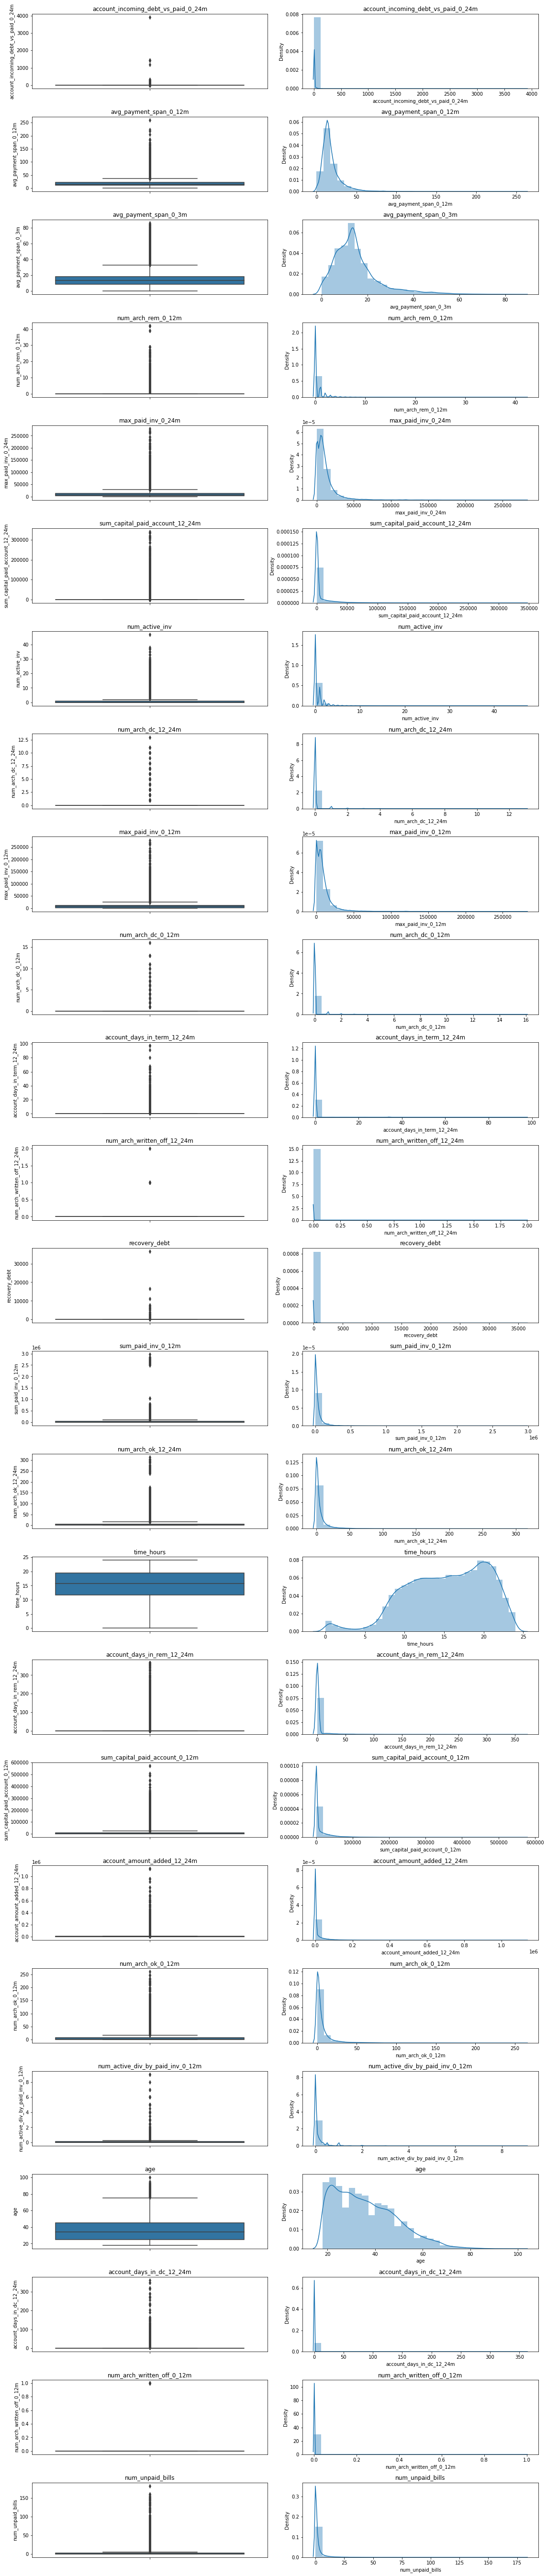

In [34]:
plot_numeric(df, numeric_features)

25it [00:11,  2.12it/s]


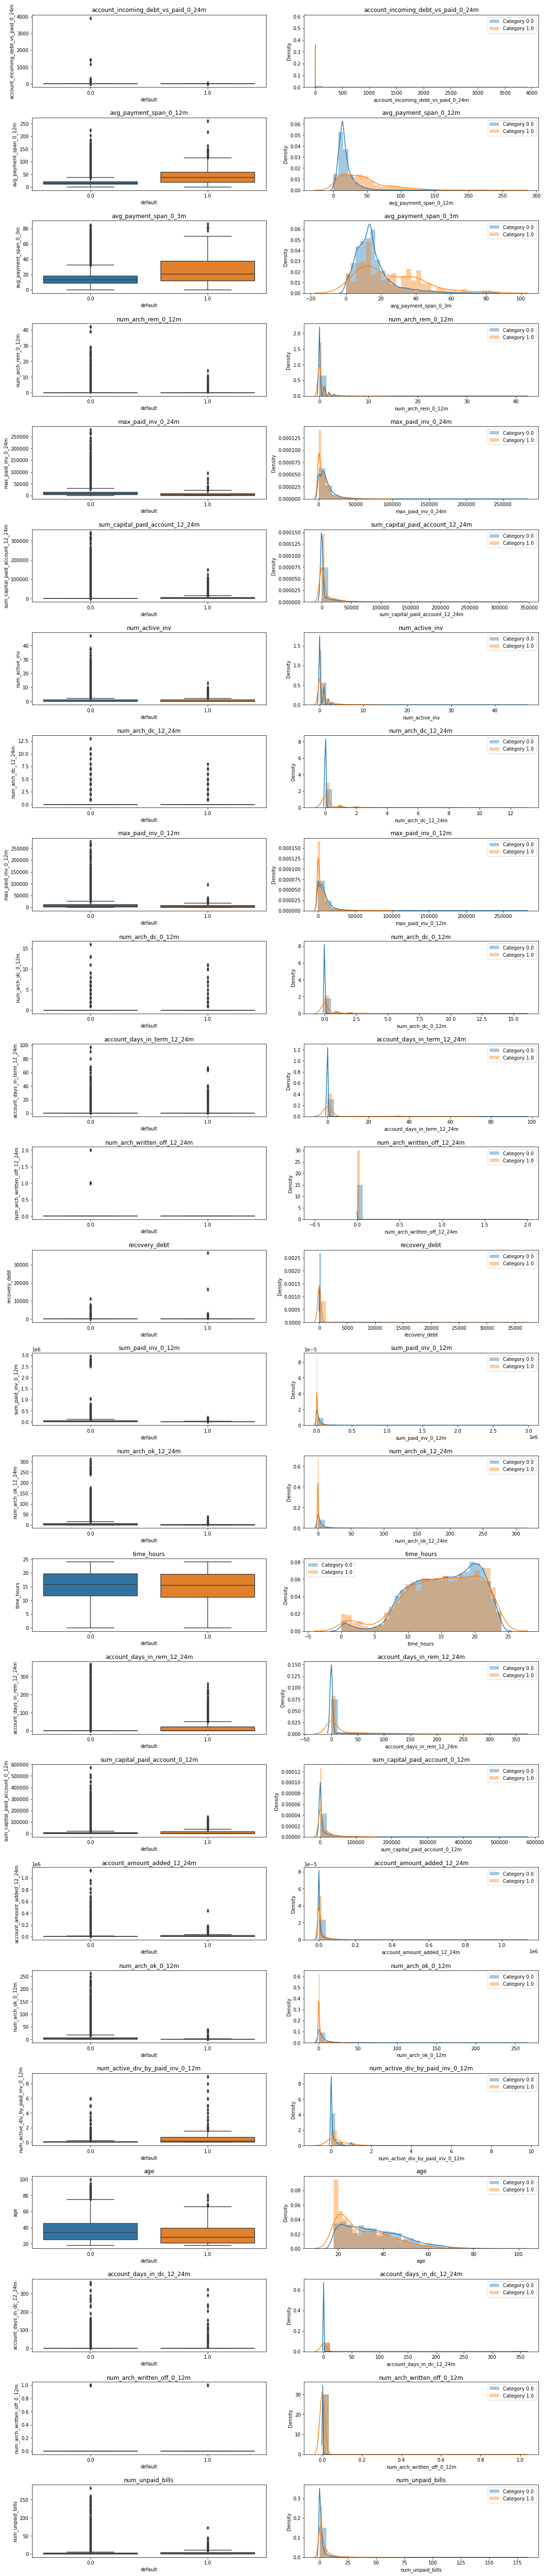

In [35]:
plot_numeric(df, numeric_features, hue=target)

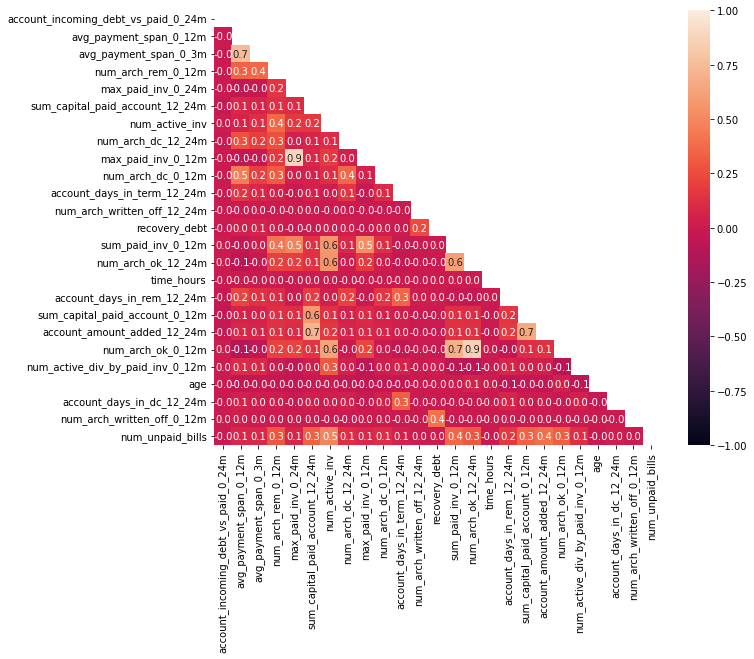

In [36]:
plot_correlation_heatmap(df, numeric_features)

First of all, let's take a closer look at correlated groups of features:

- `max_paid_inv_0_12m` and `max_paid_inv_0_24m`: It makes sense, since the latter is contained in the former. Hence, we will keep only `max_paid_inv_0_24m`.

- `avg_payment_span_0_3m` and `avg_payment_span_0_12m`: It makes sense, since the latter is contained in the former. Hence, we will keep only `avg_payment_span_0_12m` - the misisng rate is also lower.

From the analysis above, we can select following features for further development:

- `max_paid_inv_0_24m`: Selected due to correlation. It might require normalization, due to skeweness (LOG);

- `avg_payment_span_0_12m`: Selected due to correlation and lower missing rate. Also, there is a clear pattern of separation: individuals who default tend to have longer span;

- `sum_capital_paid_account_0_12m`: No missing entries and there is a slight shift. It might require normalization, due to skeweness (LOG);

- `time_hours`: No missing entries and slightly different behavior close to 0h;

- `recovery_debt`: Extreme values indicate higher propensity to default;

- `sum_capital_paid_account_12_24m`: Theoretically speaking, the higher the amount, the less propensity to default;

- `num_active_div_by_paid_inv_0_12m`: Higher probability of default for higher values;

- `sum_paid_inv_0_12m`: No missing entries and there is a slight shift.

- `account_days_in_rem_12_24m`: Higher probability of default for lower values;

- `num_arch_ok_0_12m`: No missing entries and there is a slight shift;

- `account_amount_added_12_24m`: No missing entries and there is a slight shift.

We are not considering `age` because it is a sensitive field (PII), which is **risky under GDPR**.

In [37]:
df["max_paid_inv_0_24m"] = np.log1p(df["max_paid_inv_0_24m"])
df["sum_capital_paid_account_0_12m"] = np.log1p(df["sum_capital_paid_account_0_12m"])

#### Selected Features

In [38]:
selected_features = [
    # NUMERIC
    "max_paid_inv_0_24m",
    "avg_payment_span_0_12m",
    "sum_capital_paid_account_0_12m",
    "time_hours",
    "recovery_debt",
    "sum_capital_paid_account_12_24m",
    "num_active_div_by_paid_inv_0_12m",
    "sum_paid_inv_0_12m",
    "account_days_in_rem_12_24m",
    "num_arch_ok_0_12m",
    "account_amount_added_12_24m",
    # STRING
    "merchant_group",
    "name_in_email",
    # BOOLEAN
    "has_paid",
    # CATEGORICAL
    "account_status",
    "account_worst_status_0_24m",
    "status_last_archived_0_24m",
    "status_2nd_last_archived_0_24m",
    "status_3rd_last_archived_0_24m",
    "status_max_archived_0_6_months",
    "status_max_archived_0_12_months",
    "status_max_archived_0_24_months", 
    # TARGET
    target
]

In [39]:
df = df.loc[:, selected_features]

In [40]:
cat_cols = list(
    filter(lambda x: df[x].dtype.name == "category", df.columns)
)
df[cat_cols] = df[cat_cols].astype(float)

### Training Pipeline

Now we are going to focus on model development and hyperparameter tuning.

Our choice of model is `XGBoost`, since it is one of the best-performing models available and it has some perks, such as:

- It is not needed to handle missing values;

- It deals well with high dimensionality, which can be the case when using One Hot Encoding for categorical features.

In this context, we will basically split our dataset in 3 parts:

- Training;

- Validation;

- Test.

`Training` will be used to train the model, whose hyperparameter will be tuned, based on performance against `Valiudation` set. Once hyperparameters are properly adjusted and tweaked, we will combine both sets to retrain the model, evaluating final performance agains `Test` set - here we will also be concerned with interpretability (Feature Importance and SHAP).

Moreover, we will calibrate model's probabilities as well, because we are **more interested in applying different policies based on scores**, rather than using the predicted labels.

In [41]:
# FOR REPLICABILITY
RANDOM_SEED = 99
TEST_SIZE = 0.25
K_FOLDS = 3

In [42]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

+ Hyperparameter Tuning

In [43]:
ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

In [44]:
def apply_one_hot_encoding(
    df: pd.DataFrame,
    cols: List[str],
    ohe: OneHotEncoder,
    train: bool = False
) -> Tuple[OneHotEncoder, pd.DataFrame]:
    if train:
        ohe_data = ohe.fit_transform(df[cols])
    else:
        ohe_data = ohe.transform(df[cols])
    df_oh = pd.DataFrame(
        data=ohe_data,
        columns=np.concatenate(ohe.categories_, axis=0),
        index=df.index
    )
    df_ = pd.concat([
        df.drop(columns=cols),
        df_oh
    ], axis=1)
    return ohe, df_

In [45]:
ohe, X_train = apply_one_hot_encoding(
    df=X_train, cols=string_features, ohe=ohe, train=True
)

_, X_test = apply_one_hot_encoding(
    df=X_test, cols=string_features, ohe=ohe
)

#### Hyperparameter Tuning

In order to select the best hyperparameters, we are going to rely on `RandomizedSearch`, since we are developing the model locally and do not have much computing power available.

In order to evaluate performance against validation set, we will use `average mean precision`, since it summarizes the precision-recall curve. In this scenario, we are interested in finding the best tradeoff between recall and precision, since they both are important.

- Recall: We want to identify all customers that will potentially default, so that we do not lose money;
- Precision: We want our customers to have a smooth experience, hence we cannot keep flagging good customer without any need.

In [46]:
params = {
    "min_child_weight": [1, 5, 10],
    "gamma": [0.5, 1, 1.5, 2, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "max_depth": [3, 4, 5],
    "n_estimators": np.arange(100, 700, step=100),
    "learning_rate": np.logspace(-3, -1, 8)
}

In [47]:
model = xgboost.XGBClassifier(
    objective='binary:logistic',
    silent=True,
    nthread=1
)

In [48]:
NUMBER_OF_ITERATIONS = 5

skf = StratifiedKFold(
    n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED
)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=NUMBER_OF_ITERATIONS,
    scoring="average_precision",
    n_jobs=2,
    cv=skf.split(X_train, y_train),
    verbose=3,
    random_state=RANDOM_SEED
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[13:29:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f2680b06cf0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                

In [49]:
print(f"Best Mean Average Precision: {random_search.best_score_:.2f}")
print("Best parameters:\n", random_search.best_params_)

Best Mean Average Precision: 0.15
Best parameters:
 {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.026826957952797246, 'gamma': 1.5, 'colsample_bytree': 1.0}


In [50]:
model = random_search.best_estimator_

As previously mentioned, we will also check whether the model is calibrated with the help of a **calibration curve**

In [51]:
def plot_calibration_curve(
    y_true: np.ndarray,
    y_pred: np.ndarray,
) -> None:
    prob_true, prob_pred = calibration_curve(y_true, y_pred)
    plt.plot(prob_true, prob_true, linestyle="dashed", color="navy")
    plt.plot(prob_true, prob_pred, color="green")
    plt.xlabel("Mean Predicted Value")
    plt.ylabel("Fraction of Positive")
    plt.grid(alpha=0.3)
    plt.show()

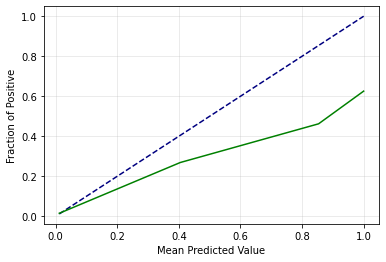

In [52]:
plot_calibration_curve(y_true=y_train, y_pred=model.predict_proba(X_train)[:, 1])

From the calibration curve, we can notice that the model underestimates the probabilities, according to the lower prevalence of positive individuals as we capture the vast majority of them in the dataset.

Hence, we should consider a calibration method, in order to have bucketized probabilities that we can actually use in order to develop differente credit policies.

In [53]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.026826957952797246,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=1, num_parallel_tree=None,
              predictor=None, ...)

In [55]:
calibrated = CalibratedClassifierCV(model, method="sigmoid", cv=K_FOLDS)
calibrated.fit(X_train, y_train)

[13:30:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[13:30:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[13:30:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    callbacks=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=1.0,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric=None,
                                                    feature_types=None,
                                                    gamma=1.5, gpu_id=None,
                                                    grow_policy=None,
                                                    importance_type=None,
                                                    

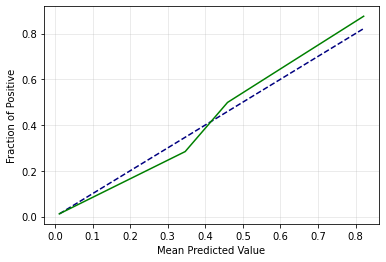

In [56]:
plot_calibration_curve(y_true=y_train, y_pred=calibrated.predict_proba(X_train)[:, 1])

Now we have a calibrated model and then we can proceed with evaluation. Why is this step improtant?

In complex ML systems - which is the scenario for credit/fraud policies, models depend on each other. Thus, calibration simplifies interaction, once it allows each model to focus on estimating its particular probabilities as well as possible. And since the interpretation is **stable**, other system components don’t need to shift whenever models change.

Last but not least, it allows us to make use of **credit scores** in a way that make more sense rather than probabilities, per se.

It makes sense that the higher the score, the less unlikely an applicant is to default. The scire is usually a logarithmic transformation of the probability of default, so that every 20p decrease in score doubles the default probability.

$score = -\log{(\frac{P}{1-P})\times\frac{20}{\log{2}}} + 600 -log(50)\times\frac{20}{\log{2}}$

The mains advantage, in reality, is that we have increased granularity as probability approaches 0 and 1.

In [57]:
def credit_score(probabilities: np.ndarray) -> np.ndarray:
    double_decrease_factor = 20 / np.log(2)
    constant = 600 - np.log(50) * double_decrease_factor
    return constant - np.log(probabilities / (1 - probabilities)) * double_decrease_factor

In [60]:
train_probabilities = calibrated.predict_proba(X_train)[:, 1]
train_scores = credit_score(train_probabilities)

In [61]:
train_scores

array([622.61679232, 604.3443556 , 623.64137632, ..., 623.77803228,
       621.13801519, 615.70365136])